In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind')
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15)
matplotlib.rcParams['text.usetex'] = False

import pandas as pd
import pystan
import corner

import pickle
import glob

import os
import sys

__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/Parallax_Runs/Highruns/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
overwrite = True
hawkstan = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
    real precalc_multinormal_lpdf(vector oo, vector oo_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;
        r = oo - oo_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }
}
data {
    int<lower = 0> N;
    real<lower= 0> Nfloat;
    vector[N] m;
    vector<lower=0>[N] m_err;
    vector[N] oo;
    vector<lower=0>[N] RlEbv;

    matrix[N, N] invc;
    real logdetc;

    real oozp_init;
    real oozp_spread;
    real muH;
}
parameters {
    //Hyperparameters
    real mu;
    real<lower=0.> sigma;
    real<lower=1.> sigo;
    real<lower=0.5,upper=1.> Q;
    real<lower=.1, upper=4000.> L;
    real oo_zp;

    //Latent parameters
    vector[N] M_infd_std;
    vector[N] Ai;
    vector<lower = 1.>[N] r_infd;
}
transformed parameters{
    //Inferred and transformed parameters
    vector[N] M_infd;

    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma * M_infd_std[n]; //Rescale the M fit
    }
}
model {
    //Define calculable properties
    vector[N] m_true;
    vector[N] oo_true;

    //Hyperparameters [p(theta_rc, L)]
    mu ~ normal(muH, 1.0); // Prior from seismo
    sigma ~ normal(0.0, 1.0);
    Q ~ normal(1., .25);
    sigo ~ normal(3.0, 1.0);
    L ~ uniform(0.1, 4000.);   // Prior on the length scale
    oo_zp ~ normal(oozp_init, oozp_spread); // Prior on the offset (in mu as)

    //Latent parameters [p(alpha_i | theta_rc, L)]
    Ai ~ normal(RlEbv, 0.05);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., 1.),
            normal_lpdf(M_infd_std[n] | 0., sigo));
    }

    //Calculable properties
    for (n in 1:N){
        m_true[n] = M_infd[n] + 5*log10(r_infd[n]) - 5 + Ai[n];
        oo_true[n] = (1000./r_infd[n]) + (oo_zp/1000.);
    }

    //Observables [p(D | theta_rc, L, alpha)]
    oo ~ precalc_multinormal(oo_true, logdetc, invc, N, Nfloat);
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
}

'''
sm = pystan.StanModel(model_code = hawkstan, model_name='hawkstan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL hawkstan_58ac0be2ad086bcaefda86eac9809b56 NOW.


In [3]:
def kernel(ra, dec, sigma, p):
    '''
    p[0] : Offset
    p[1] : Exponential decay scale
    '''
    dr = np.deg2rad(dec)
    thetaij = np.sqrt((np.subtract.outer(ra, ra)*np.cos(0.5*np.add.outer(dr, dr)))**2 + np.subtract.outer(dec, dec)**2)
    cov = p[0] * np.exp(-thetaij / p[1])
    np.fill_diagonal(cov, np.diag(cov) + sigma**2)

    if not np.all(np.linalg.eigvals(cov) > 0):
        raise ValueError("The matrix isn't positive-definite for some reason!")
    return cov

# Let construct some synthetic data for this model!

$m = M + 5*\log_{10}(r) - 5 + A$

$M$ we build from our population level model using $\mu, \sigma, Q, \sigma_o$.

$r$ we will generate from a random distribution in the same range as our data

$A$ we will generate from a normal distribution in the same range as our data

and then calculate parallax as:

$\varpi = 1000/r - \varpi_{\rm zp} / 1000$, after which we will apply noise to the parallax values normally distributed given our covariance matrix for a fixed uncertainty.$

In [4]:
np.random.seed(24601)

npts = 1000
mu = -1.63
sigma = 0.075
Q = 0.95
sigo = 3.

M_rc = np.random.randn(int(Q*npts)) * sigma + mu
M_o = np.random.randn(npts-len(M_rc)) * sigo * sigma + mu
M = np.append(M_rc, M_o)

In [5]:
df = pd.read_csv(__datdir__+'rcxyu18.csv')

In [6]:
A = np.random.randn(npts)*np.std(df.Aks)*.5 + np.median(df.Aks)

In [8]:
sel = np.random.choice(len(df),npts)
rmax = df.r_est.values[sel].max()
rmin = df.r_est.values[sel].min()
r = np.random.rand(npts)*(rmax-rmin)+rmin

In [9]:
m = M + 5 * np.log10(r) - 5 + A

In [10]:
m_err = np.ones(npts)*0.02
m_obs = np.random.normal(m, m_err)

In [14]:
oo = 1000./r
oo_err = np.ones(npts)*0.025 #mas

In [15]:
ra = df.ra.values[sel]
dec = df.dec.values[sel]
Sigma = kernel(ra, dec, oo_err, [285*10**-6, 14.])
invc = np.linalg.inv(Sigma)
logdetc = np.linalg.slogdet(Sigma)[1] * np.linalg.slogdet(Sigma)[0]

In [16]:
oozp = -29.
oo_obs = np.random.multivariate_normal(oo + (oozp/1000.), Sigma)

# Now, lets run the Stan model!

In [17]:
dat = {'N':npts,
       'Nfloat':np.float(npts),
        'm': m_obs,
        'm_err': m_err,
        'oo': oo_obs,
        'RlEbv': A,
        'logdetc': logdetc,
        'invc': invc,
        'muH': -1.61,
        'oozp_init' : 0.,
        'oozp_spread' : 1000.}


init= {'mu': -1.61,
        'sigma': 0.1,
        'Q': 0.95,
        'sigo': 4.,
        'oozp': 0.,
        'L': 1000.,
        'r_infd': r,
        'Ai': A}

In [18]:
fit = sm.sampling(data = dat, iter = 5000, chains=4, seed = 24601,
                    init = [init for i in range(4)])

## Lets plot the initial Stan results...

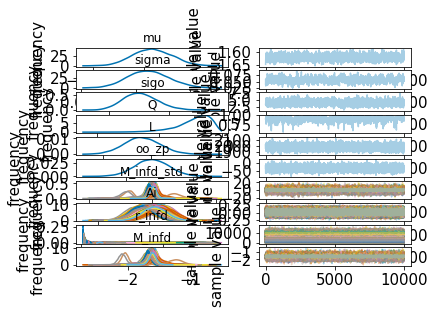

In [19]:
fit.plot()
plt.show()

In [20]:
print(fit)

Inference for Stan model: hawkstan_58ac0be2ad086bcaefda86eac9809b56.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                -1.62  3.2e-4 9.5e-3  -1.64  -1.63  -1.62  -1.61   -1.6  889.0    1.0
sigma              0.06  5.5e-4 9.5e-3   0.04   0.05   0.06   0.06   0.07  291.0   1.01
sigo               3.83    0.02   0.71   2.54   3.34    3.8   4.29   5.33  860.0    1.0
Q                  0.91  3.9e-3   0.06   0.77   0.88   0.92   0.95   0.98  203.0   1.02
L                1980.6    0.43  37.66 1907.4 1955.3 1979.7 2005.6 2056.4 7795.0    1.0
oo_zp            -30.57     0.1  12.69 -55.49 -39.02 -30.59 -21.99  -5.76  16016    1.0
M_infd_std[1]     -0.08    0.03   1.38  -2.72  -0.76  -0.04   0.68   2.23 2158.0    1.0
M_infd_std[2]      0.13    0.03   1.41  -2.28  -0.62   0.11   0.82   2.79 2969.0    1.0
M_infd_std[3]    3.0

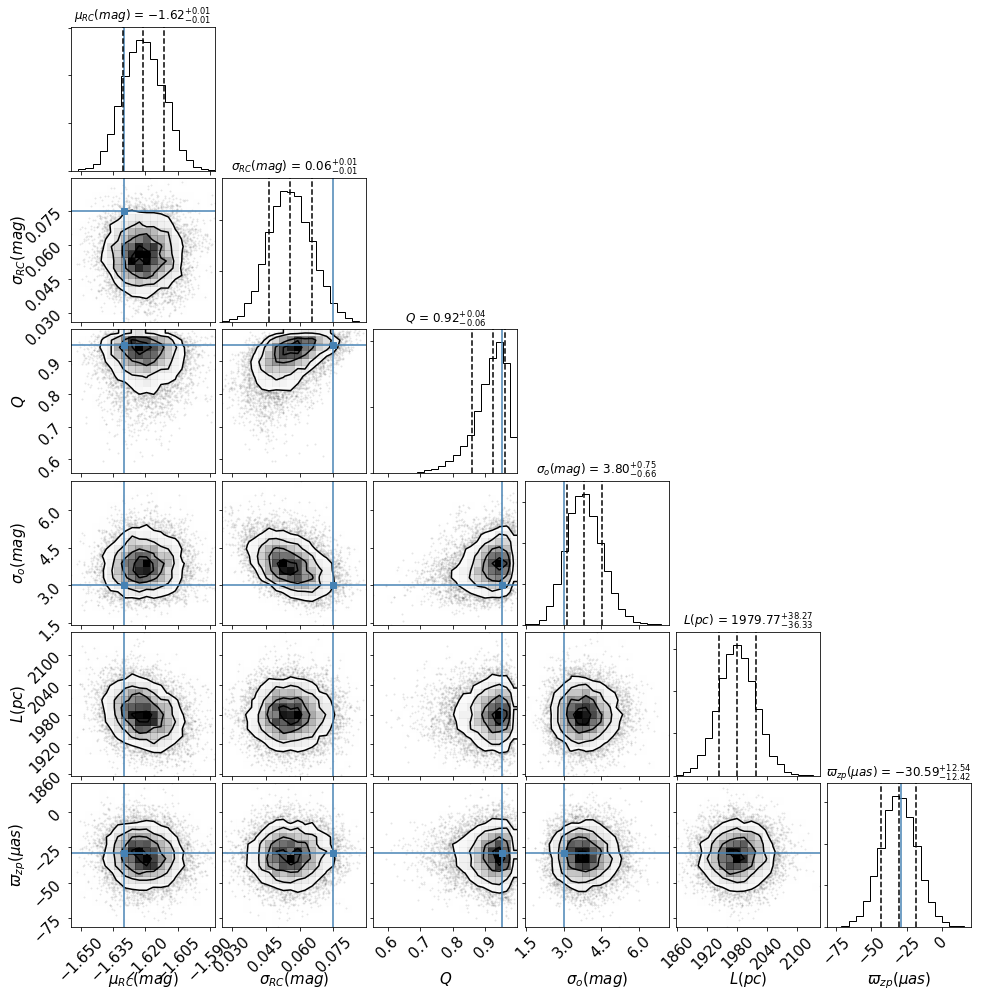

In [21]:
verbose = [r'$\mu_{RC} (mag)$',r'$\sigma_{RC} (mag)$',r'$Q$', r'$\sigma_o (mag)$',
           r'$L (pc)$', r'$\varpi_{zp} (\mu as)$']
pars = ['mu', 'sigma', 'Q', 'sigo', 'L', 'oo_zp']

truths = [mu, sigma, Q, sigo, np.nan, oozp]
chain = np.array([fit[label] for label in pars])
corner.corner(chain.T, labels=verbose,quantiles=[0.16, 0.5, 0.84], truths=truths,
              show_titles=True, title_kwargs={"fontsize":12})
plt.show()

## And lets compare to our input

In [22]:
def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [23]:
rmu = np.median(fit['mu'])
rsigma = np.median(fit['sigma'])
rsigo = (np.median(fit['sigo']))
rQ = np.median(fit['Q'])

fg = normal(M, rmu, rsigma)
bg = normal(M, rmu, rsigo)
L = rQ*fg + (1-rQ)*bg

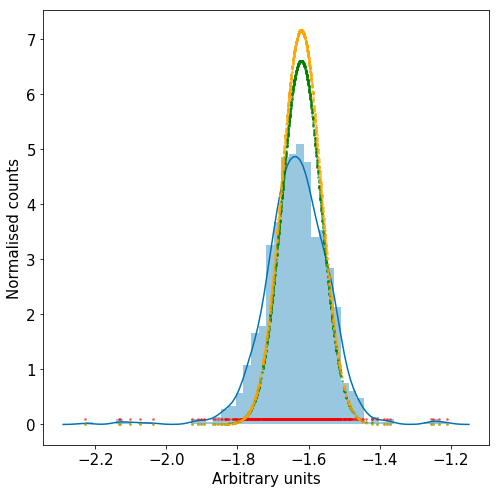

In [24]:
fig, ax = plt.subplots(1,figsize=(8,8))
sns.distplot(M,ax=ax)
ax.scatter(M,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
ax.scatter(M,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
ax.scatter(M, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

ax.set_xlabel('Arbitrary units')
ax.set_ylabel('Normalised counts')
plt.show()